In [3]:
# Extrai o dataset
!unzip 'post-processed.zip' -d dataset/

Archive:  post-processed.zip
   creating: dataset/post-processed/
   creating: dataset/post-processed/AJ_Lamas/
  inflating: dataset/post-processed/AJ_Lamas/AJ_Lamas_0001_0000.jpg  
  inflating: dataset/post-processed/AJ_Lamas/AJ_Lamas_0002_0000.jpg  
   creating: dataset/post-processed/Aaron_Eckhart/
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0001_0000.jpg  
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0001_0001.jpg  
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0001_0002.jpg  
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0002_0000.jpg  
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0002_0001.jpg  
  inflating: dataset/post-processed/Aaron_Eckhart/Aaron_Eckhart_0002_0002.jpg  
   creating: dataset/post-processed/Aaron_Guiel/
  inflating: dataset/post-processed/Aaron_Guiel/Aaron_Guiel_0001_0000.jpg  
  inflating: dataset/post-processed/Aaron_Guiel/Aaron_Guiel_0002_0000.jpg  
   creating: dat

In [4]:
# Lista os arquivos
from glob import glob
folders_names_to_run = glob("dataset/post-processed/*/*", recursive = True)
folders_names_to_run

['dataset/post-processed/Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0001_0000.jpg',
 'dataset/post-processed/Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0004_0000.jpg',
 'dataset/post-processed/Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0004_0001.jpg',
 'dataset/post-processed/Ahmed_Qureia/Ahmed_Qureia_0003_0000.jpg',
 'dataset/post-processed/Ahmed_Qureia/Ahmed_Qureia_0001_0000.jpg',
 'dataset/post-processed/Ahmed_Qureia/Ahmed_Qureia_0001_0001.jpg',
 'dataset/post-processed/Ahmed_Qureia/Ahmed_Qureia_0003_0001.jpg',
 'dataset/post-processed/Ahmed_Qureia/Ahmed_Qureia_0002_0000.jpg',
 'dataset/post-processed/Andy_Warhol/Andy_Warhol_0004_0000.jpg',
 'dataset/post-processed/Andy_Warhol/Andy_Warhol_0001_0000.jpg',
 'dataset/post-processed/Steve_Waugh/Steve_Waugh_0001_0000.jpg',
 'dataset/post-processed/Steve_Waugh/Steve_Waugh_0004_0001.jpg',
 'dataset/post-processed/Steve_Waugh/Steve_Waugh_0004_0000.jpg',
 'dataset/post-processed/Satnarine_Sharma/Satnarine_Sharma_0002_0000.jpg',
 'dataset/post-processed/Sat

In [6]:
# Carrega todas as imagens de acordo com a lista de caminhos das imagens.
import cv2
import numpy as np

list_of_images = []
for folder in folders_names_to_run:
  img = cv2.imread(folder)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  list_of_images.append(img)
all_images = np.array(list_of_images)

In [9]:
# Remove o nome das pastas e usa como etiquetas
from glob import glob
folders_names = glob("dataset/post-processed/*/*", recursive = True)
y_labels_temp = []
for folder in (folders_names):
  y_labels_temp.append(folder.replace('dataset/post-processed/',''))
y_labels_final = []
for i in (y_labels_temp):
  y_labels_final.append(i.split('/')[0])
print('Imagens no dataset =' + str(len(y_labels_final)))

Imagens no dataset =12000


In [10]:
number_of_classes = len(list(set(y_labels_final)))
print('Número de classes = '+ str(number_of_classes))

Número de classes = 2996


In [11]:
from collections import defaultdict
# Criando um dicionário com o nome das pastas, as etiquetas e os indicies de cada imagem
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_labels_final):
    class_idx_to_train_idxs[y].append(y_train_idx)
class_idx_to_train_idxs
x_train = all_images 

Nesse caso, em vez de treinar a rede neural para prever a classe de uma imagem, o objetivo é treinar a rede para aprender a medir a similaridade entre duas imagens. Cada par de imagens de treinamento é formado por uma imagem "âncora" e uma imagem "positiva", ambas escolhidas aleatoriamente de uma mesma classe. Durante o treinamento, a rede é incentivada a maximizar a similaridade entre a imagem âncora e a imagem positiva, enquanto minimiza a similaridade entre a imagem âncora e todas as outras imagens da mesma classe, bem como imagens de outras classes.

In [13]:
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay

# Definição do número de classes e do tamanho das imagens
num_classes = 200
height_width = 112 

class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        # Número de batches para a sequência
        self.num_batchs = num_batchs

    def __len__(self):
        # Retorna o tamanho da sequência
        return self.num_batchs

    def __getitem__(self, _idx):
        # Cria um array vazio de arrays com o formato das imagens
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        # O número de classes determina o número de pares de imagens retornadas 
        for class_idx in range(num_classes):
            # Busca no dicionário a lista de índices de treinamento para a classe atual
            examples_for_class = class_idx_to_train_idxs[y_labels_final[class_idx]]
            # Escolhe um índice aleatório para a âncora e o positivo
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                # Garante que o índice positivo seja diferente do índice da âncora
                positive_idx = random.choice(examples_for_class)
            # Armazena os dados de treinamento nas posições apropriadas do array vazio
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x


In [17]:
#O objetivo é determinar a similaridade entre um par de imagens que pertencem à mesma classe.
class EmbeddingModel(keras.Model):
    # sobrescreve o método train_step
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        # obtemos nossos âncoras e positivos de acordo com a estrutura que definimos anteriormente na classe AnchorPositivePairs
        # Aqui temos um lote dependendo do parâmetro do construtor
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # lotes para os pares de acordo com a categoria
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            #Aqui a similaridade é determinada entre ancoras e positivos, 
            #com uma computação element-wise, basicamente produto ponto
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )
            # este parâmetro suaviza a distribuição entre a comparação das similaridades
            temperature = 0.2
            similarities /= temperature
            
            sparse_labels = tf.range(num_classes)
            # aplica-se a entropia cruzada categórica esparsa, 
            # ela aplica um softmax para os logits, de forma a corresponder 
            # Esta perda moverá os embeddings dos pares âncora/positivos juntos e moverá todos os outros pares separadamente.
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calcula os gradientes e aplica via otimizador.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # atualiza e retorna as métricas (especificamente a métrica para o valor da perda).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}


In [18]:
""" O código abaixo implementa 3 blocos de camadas convolucionais e de pooling. 
Os tensores resultantes são mapeados em um embedding através de uma camada Dense.
Esses embeddings são normalizados para tornar possível a realização de produtos 
ponto a ponto."""

# definimos a entrada da rede neural
inputs = layers.Input(shape=(height_width, height_width, 3))
# aplicamos as camadas convolucionais
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
# aplicamos a camada de pooling global para gerar o embedding
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
# normalizamos as embeddings para possibilitar o cálculo de produtos vetoriais
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

# aplicamos a classe personalizada de EmbeddingModel para realizar o mapeamento final
model = EmbeddingModel(inputs, embeddings)

2023-03-31 23:10:45.346717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 23:10:45.346967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 23:10:45.347058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-31 23:10:45.347155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-31 23:10:45.347253: W tensorflow/c

Epoch 1/10
100/100 [==============================] - 54s 530ms/step - loss: 5.2939
Epoch 2/10
100/100 [==============================] - 53s 532ms/step - loss: 5.2970
Epoch 3/10
100/100 [==============================] - 56s 560ms/step - loss: 5.2928
Epoch 4/10
100/100 [==============================] - 56s 558ms/step - loss: 5.2940
Epoch 5/10
100/100 [==============================] - 55s 554ms/step - loss: 5.2869
Epoch 6/10
100/100 [==============================] - 53s 532ms/step - loss: 5.2463
Epoch 7/10
100/100 [==============================] - 53s 534ms/step - loss: 5.2591
Epoch 8/10
100/100 [==============================] - 53s 532ms/step - loss: 5.2227
Epoch 9/10
100/100 [==============================] - 54s 536ms/step - loss: 4.9564
Epoch 10/10
100/100 [==============================] - 53s 530ms/step - loss: 4.4474


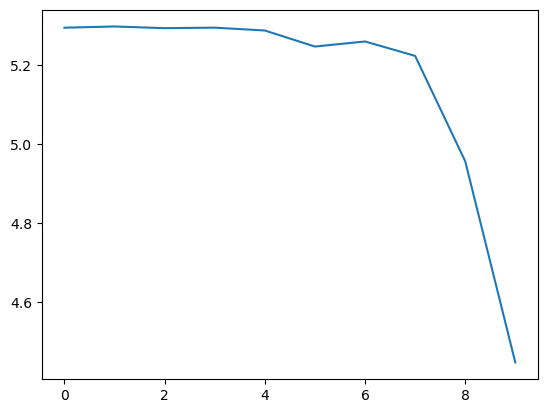

In [19]:
import matplotlib.pyplot as plt
import random

"""
Vamos executar agora o modelo. Devido às restrições de tempo, o modelo foi treinado 
com apenas uma centena de personalidades famosas por algumas épocas, uma vez que a 
perda (loss) diminuiu satisfatoriamente. O processo de treinamento com todo o conjunto 
de dados seria o mesmo, apenas mudando num_batches = 2996, que é o número de personalidades diferentes no conjunto de dados.
Compilação do modelo com otimizador Adagrad e a loss personalizada para similaridade previamente definida."""

#  Usando o otimizador Adagrad com uma taxa de aprendizagem e função de perda de entropia cruzada categórica esparsa.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
# O modelo é treinado usando a classe AnchorPositivePairs personalizada que retorna pares de imagens de uma mesma personalidade.
history = model.fit(AnchorPositivePairs(num_batchs=100), epochs=10)

# Plotando o gráfico de perda do modelo
plt.plot(history.history["loss"])
plt.show()


In [65]:
# Obtendo os vetores de descrição para as primeiras 100 imagens no conjunto de dados.
embeddings = model.predict(all_images[0:100,:,:,:])
# Obtem a matriz de scores de similaridade
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
# Ordena e retorna os exemplos mais similares para cada uma das 100 imagens
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 1) :]
near_neighbours

4/4 [==============================] - 0s 9ms/step


array([[89, 37, 32, ..., 27, 34,  0],
       [70, 95,  5, ..., 59,  2,  1],
       [95, 70,  5, ..., 33,  1,  2],
       ...,
       [70, 71,  5, ...,  8, 99, 97],
       [37, 32, 70, ..., 64, 88, 98],
       [70, 71,  5, ..., 64, 97, 99]])

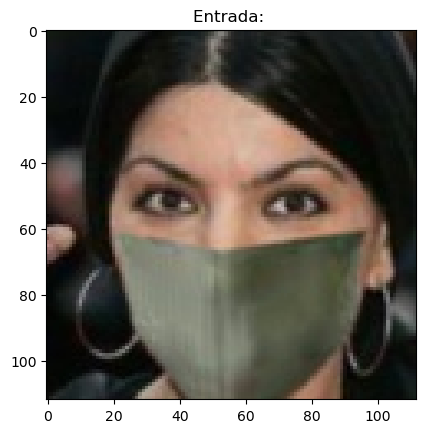

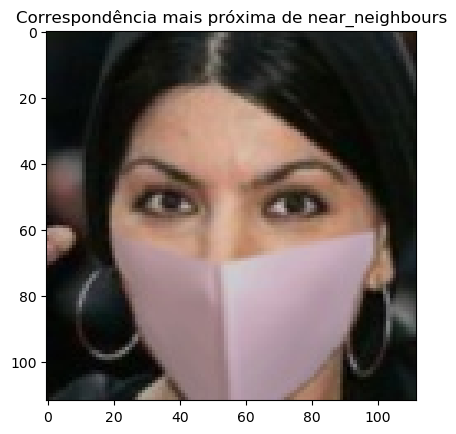

A etiqueta de entrada é: Samira_Makhmalbaf
O rótulo vizinho é:  Samira_Makhmalbaf


In [57]:
# Vendo o que resulta como a imagem mais semelhante para a imagem no 50º indice:
plt.figure()
plt.imshow(all_images[near_neighbours[50][::-1][1]])
plt.title('Entrada: ')
plt.show()

plt.figure()
plt.title('Correspondência mais próxima de near_neighbours')
plt.imshow(all_images[near_neighbours[50][::-1][2]])
plt.show()
print('A etiqueta de entrada é:', y_labels_final[50])
print('O rótulo vizinho é: ', y_labels_final[50])

In [58]:
#Criando o banco de dados: imagens e vetores de descrição
all_images[0:10,:,:,:].shape
y_labels_final[0:10]
embeddings[0:10,:]

array([[-0.6948279 , -0.14652306, -0.37205997,  0.3007141 ,  0.07219197,
        -0.00154325,  0.05740053,  0.50830954],
       [-0.71781105, -0.07611082, -0.02731523,  0.46949175, -0.3301608 ,
        -0.2170018 ,  0.28980654,  0.13304898],
       [-0.65520614,  0.03719419,  0.07111578,  0.4365243 , -0.43882513,
        -0.30016947,  0.2473076 ,  0.17285919],
       [-0.23811282,  0.08461592, -0.3359778 ,  0.5597867 ,  0.39247903,
        -0.4210226 , -0.32488978,  0.27027202],
       [-0.15189621,  0.0139444 , -0.6521103 ,  0.1754319 ,  0.6565322 ,
        -0.0183723 , -0.20345145,  0.21896163],
       [-0.02847444,  0.03859942, -0.71816343, -0.00649006,  0.67732215,
         0.03509142, -0.12232544,  0.08329578],
       [-0.30816802,  0.02768047, -0.46258473,  0.45506433,  0.49174958,
        -0.3272108 , -0.2146707 ,  0.29703552],
       [-0.20896748, -0.35564205, -0.2798759 ,  0.23089454,  0.80405045,
         0.1485725 ,  0.16422288,  0.05165756],
       [-0.63967735, -0.45571685

In [59]:
# Colocando as 100 imagens em um dicionário que funcionará como nosso banco de dados
database = {}
for i in range(100):
  database.update({ i: {'y_labels_final': y_labels_final[i], 'all_images': all_images[i,:,:,:], 'embeddings': embeddings[i,:]}})
database

{0: {'y_labels_final': 'Zydrunas_Ilgauskas',
  'all_images': array([[[40, 57, 77],
          [35, 51, 74],
          [31, 47, 72],
          ...,
          [10, 18, 21],
          [16, 23, 31],
          [15, 22, 30]],
  
         [[42, 59, 79],
          [37, 53, 76],
          [32, 48, 73],
          ...,
          [14, 21, 27],
          [15, 19, 28],
          [19, 26, 34]],
  
         [[43, 60, 80],
          [37, 53, 76],
          [33, 49, 74],
          ...,
          [24, 29, 35],
          [15, 18, 27],
          [22, 26, 37]],
  
         ...,
  
         [[26, 17, 18],
          [25, 16, 17],
          [24, 14, 15],
          ...,
          [31, 20, 18],
          [34, 20, 20],
          [34, 20, 19]],
  
         [[24, 15, 16],
          [23, 14, 15],
          [23, 13, 14],
          ...,
          [30, 18, 18],
          [33, 18, 21],
          [33, 19, 19]],
  
         [[23, 14, 15],
          [22, 13, 14],
          [23, 13, 14],
          ...,
          [28, 16, 18]

Isabella_Rossellini


array([-0.73842037, -0.21215284,  0.13088371,  0.14068227,  0.08241991,
        0.1141636 ,  0.5856533 ,  0.09994198], dtype=float32)

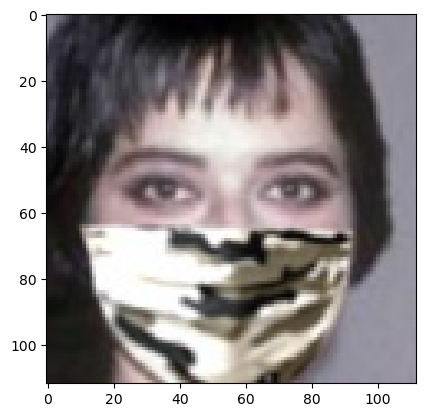

In [60]:
plt.imshow(database[99]['all_images'])
print(database[99]['y_labels_final'])
database[99]['embeddings']

In [66]:
from PIL import Image

# Adicionando o davi
foo = Image.open('davi_no_db.jpeg')
foo = foo.resize((112,112),Image.ANTIALIAS)
davi = np.array(foo)
davi.shape
feature_description_davi = model.predict(davi.reshape(1,112,112,3))
label = 'davi'
database.update({ len(database): {'y_labels_final': label, 'all_images': davi, 'embeddings': feature_description_davi}})
database
emb = database[0]['embeddings']
for i in range(1,len(database)):
  emb = np.vstack((emb,database[i]['embeddings']))
gram_matrix = np.einsum("ae,be->ab", emb, emb)
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 2) :]
near_neighbours

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_9560/2257860858.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  foo = foo.resize((112,112),Image.ANTIALIAS)


array([[ 89,  37,  32, ...,  27,  34,   0],
       [ 70,  95,   5, ...,  59,   2,   1],
       [ 95,  70,   5, ...,  33,   1,   2],
       ...,
       [ 70,  71,   5, ...,  64,  97,  99],
       [ 37,  32,  36, ...,  94, 100, 101],
       [ 37,  32,  36, ...,  94, 100, 101]])

In [67]:
# Fazendo inferência
foo = Image.open('davi_na_inferencia.jpeg')
foo = foo.resize((112,112),Image.ANTIALIAS)
davi_inf = np.array(foo)
davi_inf.shape
embed_inf = model.predict(davi_inf.reshape(1,112,112,3))
embed_inf
emb = np.vstack((emb,embed_inf))
emb.shape
gram_matrix = np.einsum("ae,be->ab", emb, emb)
near_neighbours = np.argsort(gram_matrix.T)[:, -(100 + 2) :]
near_neighbours

1/1 [==============================] - 0s 19ms/step


/tmp/ipykernel_9560/3663366366.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  foo = foo.resize((112,112),Image.ANTIALIAS)


array([[ 37,  32,  70, ...,  27,  34,   0],
       [ 95,   5,  92, ...,  59,   2,   1],
       [ 70,   5,  92, ...,  33,   1,   2],
       ...,
       [ 32,  36,  26, ...,  94, 101, 100],
       [ 32,  36,  26, ...,  94, 101, 100],
       [ 71,   2,  37, ...,  57,  55, 102]])

array([100, 101,  94,  91,  96,  87,  93,  51, 102,  95,  98,   9,  88,
         7,  10,  55,  57,  58,  54,  82,  53,  85,  56,  86,  52,  83,
        12,  11,   8,  65,  13,  17,  90,  84,  81,  64,  99,  14,  68,
        78,  77,  25,  63,  74,  76,  75,  61,  72,  92,  73,  97,  23,
        79,  20,  69,  67,  46,  16,  40,  15,  39,  22,   5,  66,  45,
        80,  43,  62,  44,  21,  59,  48,  60,  24,   4,  19,  42,  47,
         0,  18,  49,  50,  34,  89,  41,  71,  38,  27,  70,   6,  33,
         1,   3,  28,  35,  29,  30,   2,  31,  26,  36,  32])

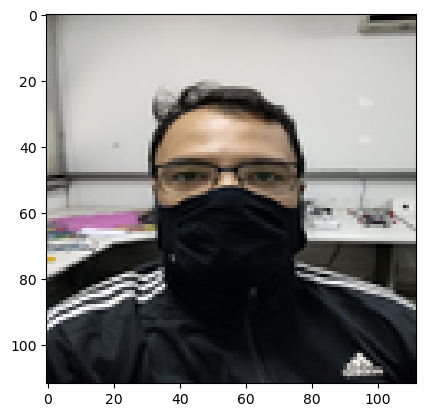

In [68]:
# A imagem de treinamento está no índice 101. Esta é a imagem que testamos:
plt.imshow(davi_inf)
near_neighbours[101][::-1]

davi


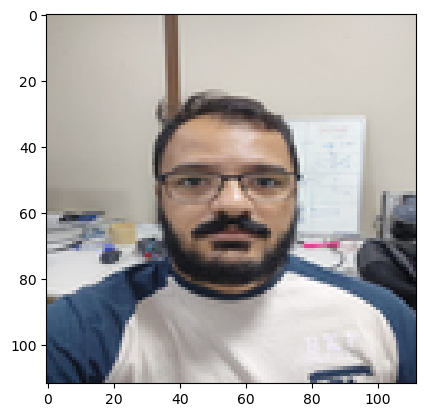

In [69]:
# Verificando quem é o par(O davi sem mascara)
plt.imshow(database[near_neighbours[101][::-1][1]]['all_images'])
print(database[near_neighbours[101][::-1][1]]['y_labels_final'])